In [14]:
import os
import time
import json
import random
import copy
from pathlib import Path
try:
    import kagglehub
except ImportError:
    !pip install -q kagglehub
    import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство для вычислений: {device}")
if str(device) == 'cpu':
    print("ВНИМАНИЕ: Вы не включили GPU! Обучение будет идти вечность.")

Устройство для вычислений: cuda


# Скачиваем датасет с Kaggle...

In [16]:

path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
print("Path to dataset files:", path)
DATA_DIR = Path(path)

Using Colab cache for faster access to the 'mushrooms-classification-common-genuss-images' dataset.
Path to dataset files: /kaggle/input/mushrooms-classification-common-genuss-images


In [17]:
if (DATA_DIR / 'Mushrooms').exists():
    DATA_DIR = DATA_DIR / 'Mushrooms'

print(f"Данные готовы: {DATA_DIR}")

Данные готовы: /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms


# Анализируем данные

In [18]:
classes = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
class_counts = {c: len(list((DATA_DIR / c).glob('*'))) for c in classes}

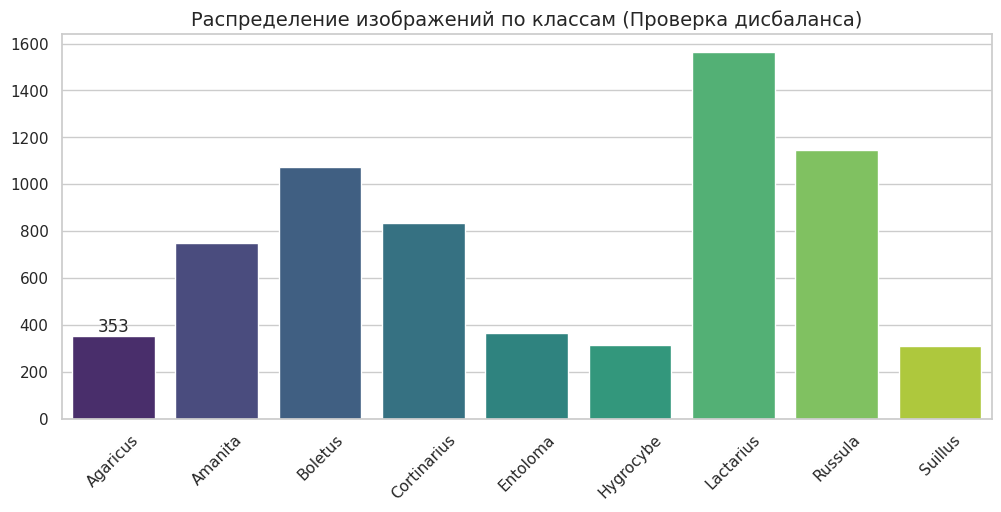

In [19]:
plt.figure(figsize=(12, 5))
barplot = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), legend=False, palette="viridis")
plt.title("Распределение изображений по классам (Проверка дисбаланса)", fontsize=14)
plt.xticks(rotation=45)
plt.bar_label(barplot.containers[0])
plt.show()

# Примеры того, что видит сеть

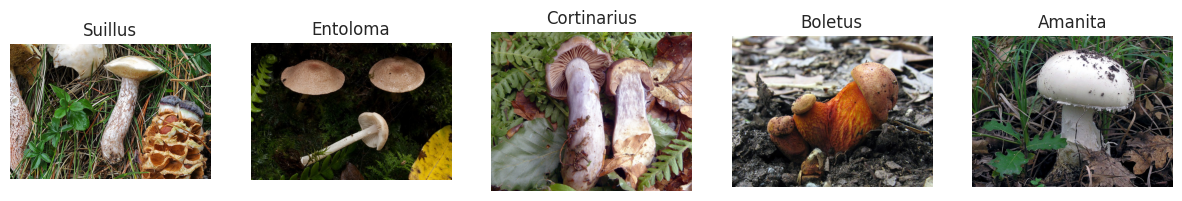

In [20]:
plt.figure(figsize=(15, 8))
for i, c in enumerate(random.sample(classes, min(len(classes), 5))):
    img_path = random.choice(list((DATA_DIR / c).glob('*')))
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")
plt.show()

In [21]:
BATCH_SIZE = 32
IMG_SIZE = 224

In [22]:
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms)
class_names = full_dataset.classes

# ВЫЧИСЛЕНИЕ ВЕСОВ КЛАССОВ  

**Формула вычисления веса для класса:**

$$
\text{вес_класса} = \frac{N_{\text{samples}}}{N_{\text{classes}} \times N_{\text{samples_class}}}
$$

где:
 - N_samples — общее количество образцов в датасете,
 - N_classes — количество классов,
 - N_samples_class — количество образцов в текущем классе.


In [24]:

targets = full_dataset.targets
count_array = np.bincount(targets)
total_samples = len(full_dataset)

class_weights = total_samples / (len(class_names) * count_array)
weights_tensor = torch.FloatTensor(class_weights).to(device)

print("\nРассчитанные веса классов (штрафы для модели):")
for name, weight in zip(class_names, class_weights):
    print(f"{name:15} : {weight:.4f}")


Рассчитанные веса классов (штрафы для модели):
Agaricus        : 2.1133
Amanita         : 0.9947
Boletus         : 0.6952
Cortinarius     : 0.8923
Entoloma        : 2.0495
Hygrocybe       : 2.3608
Lactarius       : 0.4773
Russula         : 0.6498
Suillus         : 2.3987


# Разбиваем на Train / Val (80/20)

In [25]:

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Создание и обучение модели

In [26]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1') # Загружаем EfficientNet-B0"

for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
NUM_EPOCHS = 8


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print(f"Начинаем обучение на {NUM_EPOCHS} эпох...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = 100 * val_correct / val_total
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")

print("Обучение завершено")

Начинаем обучение на 8 эпох...
Epoch 1/8 | Train Loss: 1.6488 Acc: 44.76% | Val Loss: 1.3253 Acc: 55.77%
Epoch 2/8 | Train Loss: 1.2387 Acc: 57.85% | Val Loss: 1.1588 Acc: 58.45%
Epoch 3/8 | Train Loss: 1.0897 Acc: 61.09% | Val Loss: 1.1149 Acc: 60.46%
Epoch 4/8 | Train Loss: 1.0219 Acc: 63.79% | Val Loss: 1.0749 Acc: 59.64%
Epoch 5/8 | Train Loss: 0.9841 Acc: 64.27% | Val Loss: 1.0228 Acc: 61.73%
Epoch 6/8 | Train Loss: 0.9395 Acc: 65.44% | Val Loss: 1.0059 Acc: 63.22%
Epoch 7/8 | Train Loss: 0.8947 Acc: 67.19% | Val Loss: 1.0131 Acc: 62.77%
Epoch 8/8 | Train Loss: 0.8737 Acc: 67.94% | Val Loss: 0.9882 Acc: 63.74%
Обучение завершено


# Графики обучения

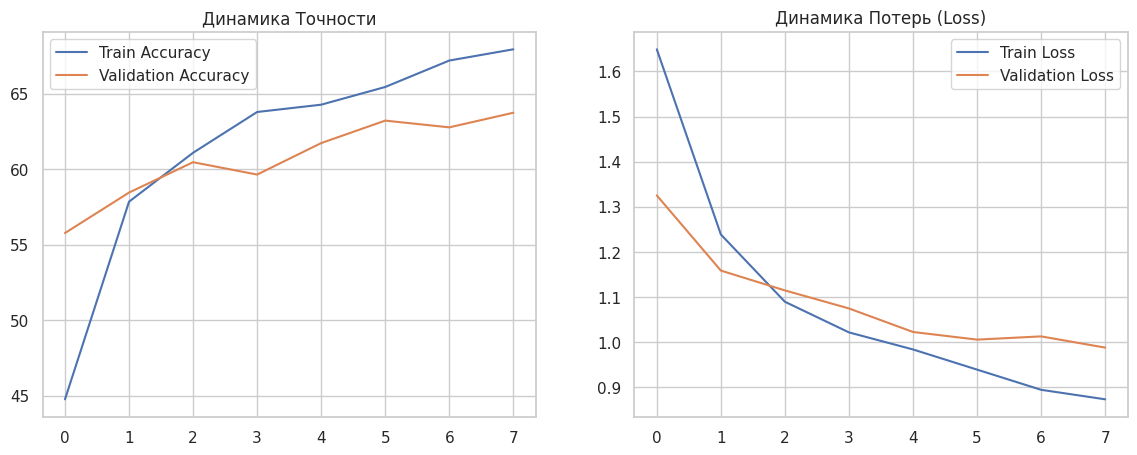

In [27]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Динамика Точности')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Динамика Потерь (Loss)')
plt.legend()
plt.show()

# Матрица Ошибок

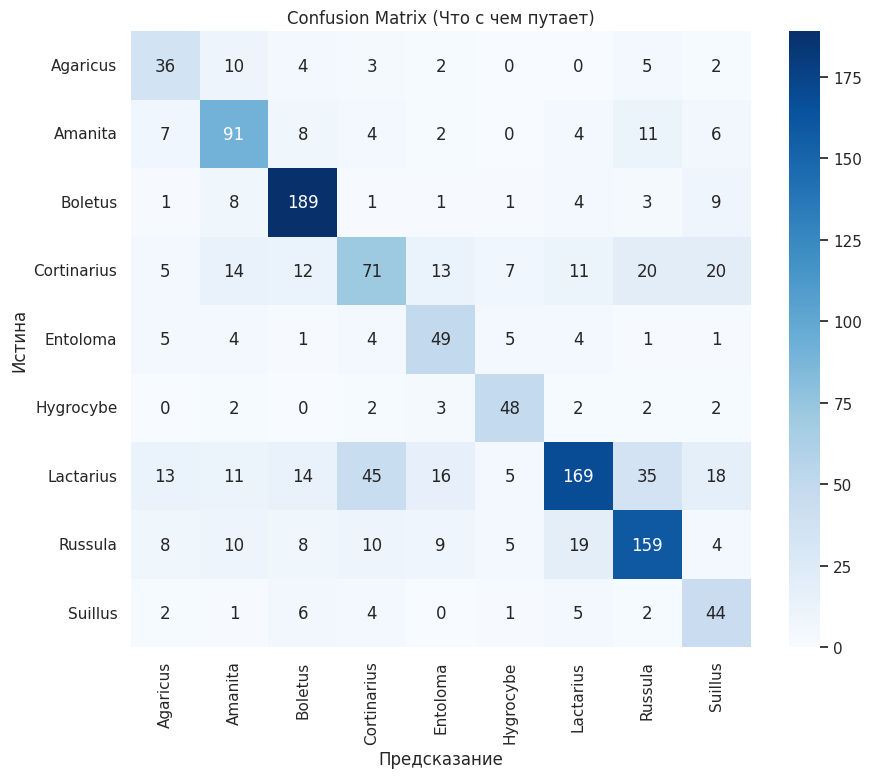

In [28]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Что с чем путает)')
plt.ylabel('Истина')
plt.xlabel('Предсказание')
plt.show()

# Classification Report (Precision/Recall Heatmap)
Детальный отчет по метрикам:

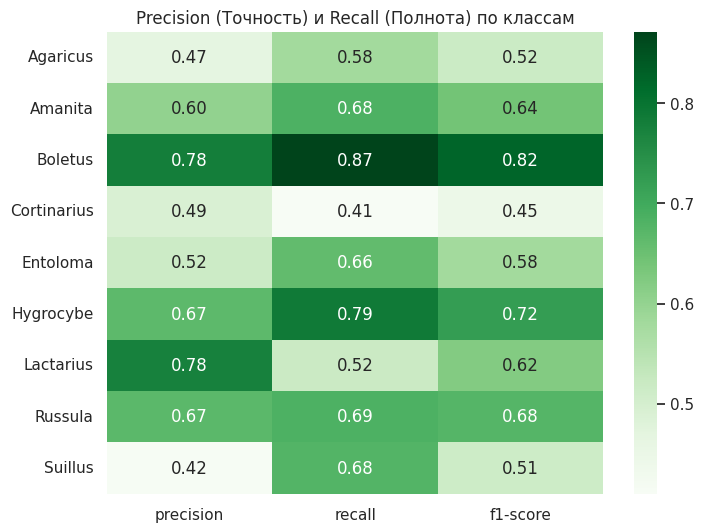

In [29]:


report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3, :-1]

plt.figure(figsize=(8, 6))
sns.heatmap(df_report, annot=True, cmap="Greens", fmt=".2f")
plt.title("Precision (Точность) и Recall (Полнота) по классам")
plt.show()

# Top-3 Accuracy

In [30]:

def calc_topk(loader, k=3):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, topk = outputs.topk(k, dim=1)
            correct += topk.eq(labels.view(-1, 1).expand_as(topk)).sum().item()
            total += labels.size(0)
    return 100 * correct / total

top3_acc = calc_topk(val_loader, k=3)
print(f"\n Top-1 Accuracy: {history['val_acc'][-1]:.2f}%")
print(f" Top-3 Accuracy: {top3_acc:.2f}% (Правильный ответ в топ-3)")


 Top-1 Accuracy: 63.74%
 Top-3 Accuracy: 89.95% (Правильный ответ в топ-3)


# СОХРАНЕНИЕ НА GOOGLE DRIVE

In [31]:
from google.colab import drive
import os


drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/ТИПиС'
os.makedirs(save_path, exist_ok=True)


torch.save(model.state_dict(), os.path.join(save_path, 'mushroom_model.pth'))


with open(os.path.join(save_path, 'config.json'), 'w') as f:
    json.dump(class_names, f)

print(f"\n УСПЕХ! Файлы сохранены в папку: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 УСПЕХ! Файлы сохранены в папку: /content/drive/MyDrive/ТИПиС
